# Example 2b

* Same as example 2, but with upper limit on emission rate

In [1]:
import multicarrier
import plots
import matplotlib.pyplot as plt
import IPython.display
outpath = "result_example2/"

# 1 oil barrel = 0.158987 m3
# 1 $/barrel = 8.4 $/m3
# 50 $/barrel = 419 $ /m3
carrier_properties = {
    'wellstream': {
            'composition': {'gas':0.995, 'oil':0.002, 'water':0.003} #Sm3
            },
    'water': {},
    'oil': {'export_price': 419, #EUR/Sm3
            #'energy_value':36000, #MJ/Sm3
            #'CO2content':260 #kg/MWh
            },
    'gas':{'energy_value':40, #MJ/Sm3
           'rho_density': 0.84, # kg/Sm3
           'CO2content':2.34, #kg/Sm3, SSB 2016 report
           'export_price': 0.419, #$/Sm3
           'Tb_basetemp_K':273+15,
           'Pb_basepressure_MPa':0.101,
           'G_gravity':0.6,
           'Z_compressibility':0.9,
           'k_heat_capacity_ratio':1.27,
           'R_individual_gas_constant': 500, # J/kg K
           }, 
    'el':{'energy_value':1,
          #'CO2content':0,
          'export_price': 50, #EUR/MWh
          },
    'heat':{#'CO2content':0
            },
    }

In [2]:
mc = multicarrier.Multicarrier(loglevel="INFO",quadraticConstraints=False)
data,profiles = multicarrier.read_data_from_xlsx("data_example2.xlsx", carrier_properties)
#data['paramDeviceEnergyInitially'][17]=2.5 # MWh - battery
for dev in ['GT1','GT2']:
    data['paramDeviceOnTimestepsInitially'][dev] = 10
    data['paramDeviceIsOnInitially'][dev] = 1
data['paramParameters']['emissionRateMax'] = 7
#data['paramParameters']['emissionIntensityMax'] = 56 # infeasible
instance = mc.createModelInstance(data,profiles)
#print("Writing instance to file.")
#instance.pprint(outpath+"problem_instance.txt")
#plots.plotProfiles(profiles,filename=None)

2020-04-17 17:37:13 INFO: TODO: objective function definition
2020-04-17 17:37:13 INFO: TODO: separator power (eta) and heat (eta2) demand
2020-04-17 17:37:13 INFO: Compressor - output pressure fixed at nominal value?
2020-04-17 17:37:13 INFO: TODO: gas turbine power vs heat output
2020-04-17 17:37:13 INFO: TODO: startup cost
2020-04-17 17:37:13 INFO: TODO: el source: dieselgen, fuel, on-off variables
2020-04-17 17:37:13 INFO: TODO: liquid pump approximation ok?
2020-04-17 17:37:13 INFO: TODO: oil pump pressure difference approximation ok?
2020-04-17 17:37:13 INFO: TODO: flow vs pressure equations for liquid flows


TODO: startup delay does not work with Pmin>0


2020-04-17 17:37:14 INFO: NumExpr defaulting to 4 threads.
C:\Users\hsven\code\hybrid_energy_system\multicarrier.py:2136: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\hsven\code\hybrid_energy_system\multicarrier.py:2145: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [5]:
dotG=plots.plotNetwork(mc,timestep=None,filename=None)
#IPython.display.SVG(dotG.create_svg()) #original size, vector graphics
#IPython.display.Image(dotG.create_png()) #scales automatically to page width

## Solve

In [8]:
status = mc.solveMany(solver="cbc",timerange=[0,144],write_yaml=False,timelimit=60)

# Save results to file:
#mc.exportSimulationResult(filename=outpath+"simresult.xlsx")

# Analyse results:

sumCO2 = mc._dfCO2rate.mean()
co2intensity = mc._dfCO2intensity.mean()
exportrevenue = mc._dfExportRevenue.mean()
print("Mean CO2 emission rate      = {:.1f} kgCO2/s".format(sumCO2))
print("Mean CO2 emission intensity = {:.1f} kgCO2/Sm3oe".format(co2intensity))
print("Mean export revenue         =",*["{}:{:.1f} ".format(x,v) for x,v in mc._dfExportRevenue.mean().items() if v!=0],"$/s")

2020-04-17 17:40:42 INFO: Using solver timelimit=60
2020-04-17 17:40:42 INFO: Solving timestep=0
2020-04-17 17:40:45 INFO: Solving timestep=6
2020-04-17 17:40:48 INFO: Solving timestep=12
2020-04-17 17:40:50 INFO: Solving timestep=18
2020-04-17 17:40:51 INFO: Solving timestep=24
2020-04-17 17:40:52 INFO: Solving timestep=30
2020-04-17 17:40:54 INFO: Solving timestep=36
2020-04-17 17:40:55 INFO: Solving timestep=42
2020-04-17 17:40:57 INFO: Solving timestep=48
2020-04-17 17:40:58 WARNING: Negative number in varDeviceFlow - set to zero (('battery', 'el', 'in', 22))
2020-04-17 17:40:58 INFO: Solving timestep=54
2020-04-17 17:41:00 WARNING: Negative number in varDeviceFlow - set to zero (('battery', 'el', 'in', 16))
2020-04-17 17:41:00 INFO: Solving timestep=60
2020-04-17 17:41:02 INFO: Solving timestep=66
2020-04-17 17:41:05 INFO: Solving timestep=72
2020-04-17 17:41:08 INFO: Solving timestep=78
2020-04-17 17:41:09 INFO: Solving timestep=84
2020-04-17 17:41:10 INFO: Solving timestep=90
20

Mean CO2 emission rate      = 6.7 kgCO2/s
Mean CO2 emission intensity = 50.1 kgCO2/Sm3oe
Mean export revenue         = oil:38.8  gas:18.1  $/s


## Analyse results

In [20]:
#print("CHECK nominal pressure values at t=...")
#mc.computeEdgePressureDrop(tstep)

In [55]:
tstep=1
gCombined = plots.plotNetwork(mc,timestep=tstep)#,filename=outpath+"network_combined.png")
gEl = plots.plotNetwork(mc,timestep=tstep,only_carrier='el')
gHeat = plots.plotNetwork(mc,timestep=tstep,only_carrier='heat')
gGas = plots.plotNetwork(mc,timestep=tstep,only_carrier='gas')
gOil = plots.plotNetwork(mc,timestep=tstep,only_carrier='oil')
gWater = plots.plotNetwork(mc,timestep=tstep,only_carrier='water')
#IPython.display.Image(gCombined.create_png())
#IPython.display.Image(gGas.create_png())

In [9]:
plots.plotter="plotly"
#plots.plot_SumPowerMix(mc,carrier="el",filename=outpath+"el_sum_opt.png")
fig=plots.plot_SumPowerMix(mc,carrier="el",filename=None)

ValueError: Index contains duplicate entries, cannot reshape

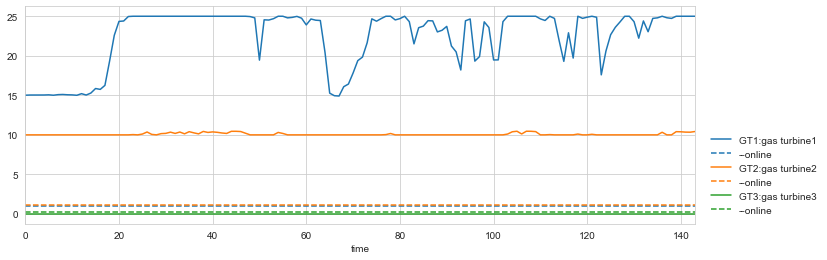

In [57]:
gts = [d for d in mc.instance.setDevice 
       if mc.instance.paramDevice[d]['model']=='gasturbine']
#plots.plot_deviceprofile(mc,devs=gts,profiles=profiles,filename=outpath+"GTs_opt.png")
plots.plot_deviceprofile(mc,devs=gts,profiles=profiles,filename=None)


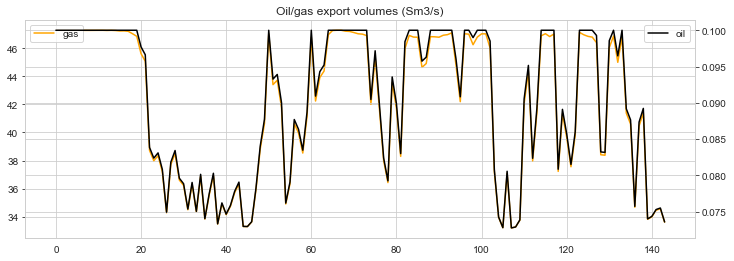

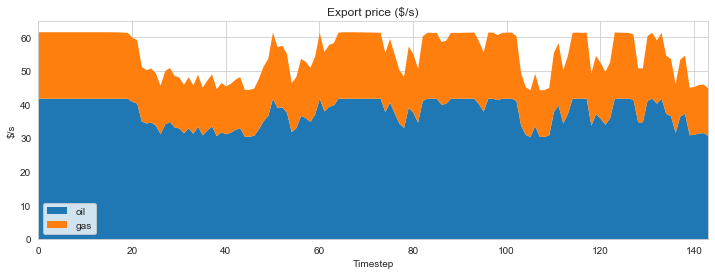

In [58]:
plt.figure(figsize=(12,4))
ax=plt.gca()
labels=[]
df=mc._dfDevicePower.unstack(0)[['ex_g','ex_o']]
ax.plot(df['ex_g'],label='gas',color='orange')
ax.legend(loc='upper left')
ax2=ax.twinx()
ax2.plot(df['ex_o'],label='oil',color='black')
ax2.legend(loc='upper right')
plt.title("Oil/gas export volumes (Sm3/s)")

#    ax.legend(labels,loc='lower left', bbox_to_anchor =(1.01,0),
#              frameon=False)
#plt.savefig(outpath+"export.png",bbox_inches = 'tight')

plots.plot_ExportRevenue(mc)

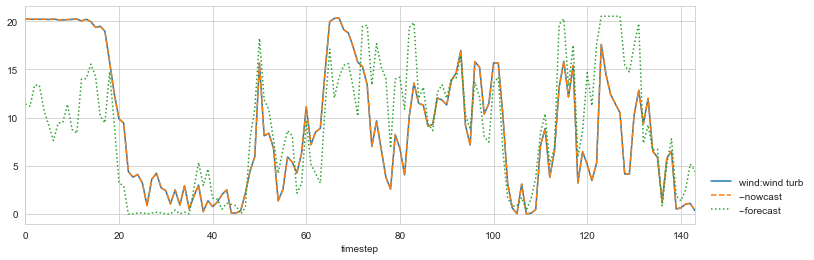

In [59]:
if 'wind' in mc.instance.setDevice:
    plots.plot_deviceprofile(mc,devs=['wind'],profiles=profiles,
                             filename=None)#outpath+"WT_opt.png")

In [60]:
if 'battery' in mc.instance.setDevice:
    plots.plot_devicePowerEnergy(mc,'battery',
                                 filename=None)#outpath+"battery_opt.png")
    multicarrier.Plots.plotDevicePowerLastOptimisation1(mc,device='battery',
                filename=None)#outpath+"lastopt_battery.png")

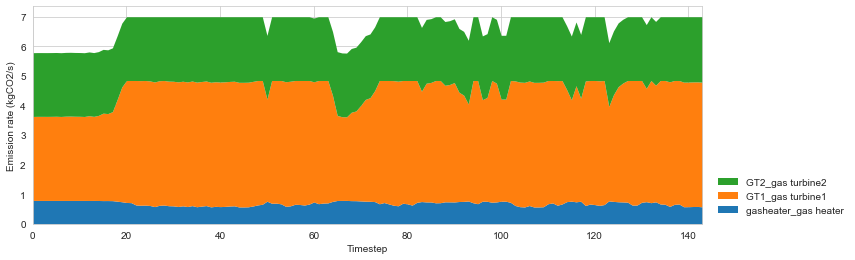

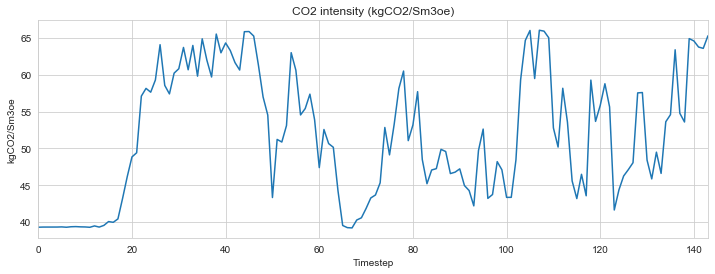

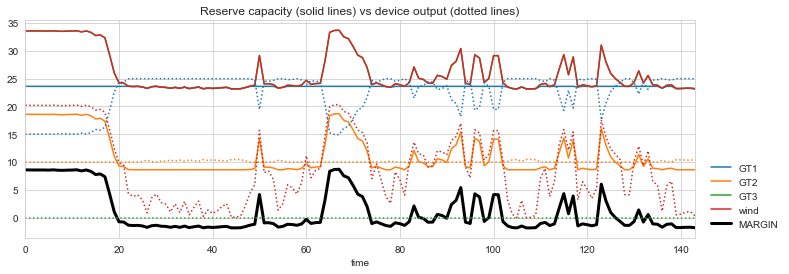

In [61]:
plots.plot_CO2rate_per_dev(mc,reverseLegend=True)#,filename=outpath+"co2rate_opt.png")
plots.plot_CO2_intensity(mc)#,filename=outpath+"co2intensity_opt.png")
plots.plotElReserve(mc)#,filename=outpath+"elReserve.png")


p=plots.plot_df(mc._dfDevicePower,id_var="device",filename=None,#outpath+"plotly.html",
              title="Device Power",ylabel="Power (MW)")

# Last optimisisation (results for a horizon)
#multicarrier.Plots.plotDeviceSumPowerLastOptimisation(instance,
#                                                      filename=outpath+"lastopt_devsum_el.png")
#multicarrier.Plots.plotEmissionRateLastOptimisation(instance,filename=outpath+"lastopt_co2out.png")


